# Optimizing Scikit-Learn with Array API and Numba

https://scikit-learn.org/stable/modules/array_api.html
https://scikit-learn.org/stable/modules/lda_qda.html
https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html


In [1]:
from egglog.exp.array_api import *
from egglog.exp.array_api_numba import *
from egglog.exp.array_api_program_gen import *
from sklearn import config_context
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def run_lda(x, y):
    lda = LinearDiscriminantAnalysis()
    return lda.fit(x, y).transform(x)


X_np, y_np = make_classification(random_state=0, n_samples=1000000)
run_lda(X_np, y_np)


array([[ 0.64233002],
       [ 0.63661245],
       [-1.603293  ],
       ...,
       [-1.1506433 ],
       [ 0.71687176],
       [-1.51119579]])

In [4]:
X_arr = NDArray.var("X")
X_orig = copy(X_arr)

assume_dtype(X_arr, X_np.dtype)
assume_shape(X_arr, X_np.shape)
assume_isfinite(X_arr)

y_arr = NDArray.var("y")
y_orig = copy(y_arr)

assume_dtype(y_arr, y_np.dtype)
assume_shape(y_arr, y_np.shape)
assume_value_one_of(y_arr, (0, 1))


In [5]:
with EGraph([array_api_module]) as egraph:
    with config_context(array_api_dispatch=True):
        X_r2 = run_lda(X_arr, y_arr)
egraph = EGraph([array_api_numba_module])
egraph.register(X_r2)
egraph.run(10000)
X_r2_optimized = egraph.extract(X_r2)


In [6]:
egraph = EGraph([array_api_module_string])
fn_program = ndarray_function_two(X_r2_optimized, X_orig, y_orig)
egraph.register(fn_program)
egraph.run(10000)
fn = egraph.load_object(egraph.extract(fn_program.py_object))

assert np.allclose(run_lda(X_np, y_np), fn(X_np, y_np))


In [10]:
from numba import njit

fn_numba = njit(fn)
assert np.allclose(run_lda(X_np, y_np), fn_numba(X_np, y_np))


/var/folders/xn/05ktz3056kqd9n8frgd6236h0000gn/T/.tmpLdLTvY.py:62: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'F', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  _51 = _39 @ _46[2].T[slice(None, None, None), slice(None, _50.item(), None)]


In [23]:
import timeit
import pandas as pd

stmts = {
    "sklearn": "run_lda(X_np, y_np)",
    "sklearn_dispatch": "with config_context(array_api_dispatch=True):\n    run_lda(X_np, y_np)",
    "array_api": "fn(X_np, y_np)",
    "numba": "fn_numba(X_np, y_np)",
}
df = pd.DataFrame.from_dict(
    {name: timeit.repeat(stmt, globals=globals(), number=1, repeat=10) for name, stmt in stmts.items()}
)

df


,sklearn,numba,array_api,sklearn_dispatch
0,2.876868,1.094412,1.461843,1.382058
1,2.706290,1.142791,1.509948,1.466938
2,2.853351,1.129803,1.473648,1.454945
3,2.720352,1.066502,1.487564,1.441763
4,2.649939,1.062415,1.498319,1.477961
5,2.612419,1.064383,1.475330,1.402335
6,2.617866,1.057387,1.486030,1.421148
7,2.696055,1.079144,1.475846,1.404037
8,2.641883,1.074097,1.501948,1.417458
9,2.681767,1.068637,1.504428,1.421889


In [28]:
df.mean()


sklearn             2.705679
numba               1.083957
array_api           1.487490
sklearn_dispatch    1.429053
dtype: float64

/usr/local/Caskroom/miniconda/base/envs/egg-smol-python/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


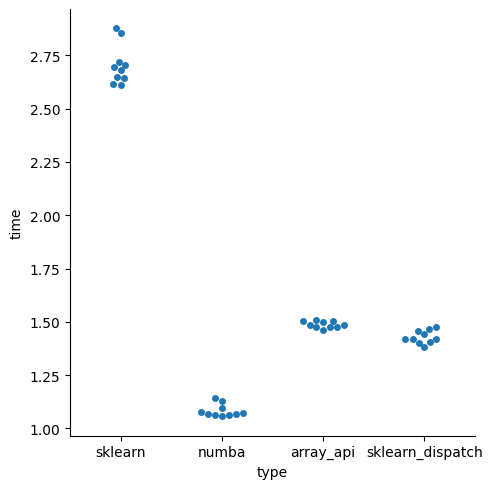

In [27]:
import seaborn as sns

df_melt = pd.melt(df, var_name="type", value_name="time")
sns.catplot(data=df_melt, x="type", y="time", kind="swarm")


In [ ]:
# %load_ext line_profiler
# %lprun -f fn fn(X_np, y_np)
